In [16]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [17]:
'''
무비렌즈 데이터 셋
20,000,263 평점
27,278 영화
138,493 사용자
'''

'\nMovieLens 20M Dataset\n20,000,263 ratings\n27,278 movies\n138,493 users\n'

In [18]:
# 데이터 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratings.csv'])
ratingDF = pd.read_csv(current_path + file)

In [19]:
# 적절한 데이터 유형으로 필드 변환
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: \
                    datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [20]:
# 향 후 더 빠른 로딩을 위해 데이터 프레임을 피클로 저장
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingPickle'])
ratingDF.to_pickle(current_path + pickle_file)
ratingDF = pd.read_pickle(current_path + pickle_file)

In [21]:
# 데이터 미리 보기
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [22]:
# 전체 데이터 셋에 대한 요약 통계 계산

# 20,000,263 평점
# 26,744 영화 수
# 138,493 사용자 수
# 144 사용자별 평균 평점

n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [23]:
# 상위 1000개 영화 추출로 데이터 셋 크기 축소
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
                "rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [24]:
# 사용자 1000명 샘플링으로 데이터 셋 크기 축소

userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [25]:
# 영화 ID 다시 인덱싱
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [26]:
# 사용자 ID 다시 인덱싱
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [27]:
# 새롭게 병합된 데이터프레임 생성 
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)

ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


In [28]:
# 피클로 저장
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingReducedPickle'])
ratingDFX3.to_pickle(current_path + pickle_file)
ratingDFX3 = pd.read_pickle(current_path + pickle_file)

In [29]:
# 축소된 데이터셋의 요약 통계 계산
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


In [30]:
# 각각 데이터 셋의 5%가 되도록 검증 및 테스트 셋 분할
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50, \
                                        shuffle=True, random_state=2018)

In [31]:
# 훈련, 검증 및 테스트 데이터 셋의 크기 확인
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  81191
Size of validation set:  4511
Size of test set:  4511


In [32]:
# 훈련을 위한 평점 행렬 생성
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [33]:
ratings_train.shape

(1000, 1000)

In [34]:
# 훈련 평점 행렬 희소성 계산
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


In [35]:
# 검증을 위한 평점 행렬 생성
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [36]:
# 테스트를 위한 평점 행렬 생성
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [37]:
# 검증 평점 행렬의 희소성 계산
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.45%


In [38]:
# 실험1 - 단순 평균 평점 3.5로 예측 할당한 경우 베이스라인으로 MSE 계산

In [39]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [40]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

In [41]:
naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

Mean squared error using naive prediction: 1.055420084238528


In [42]:
# 실험2 - 사용자별 모든 다른 영화에 대한 평균 평점에 기반한 예측

In [43]:
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


In [44]:
# 실험3 - 영화별 모든 다른 사용자에 대한 평균 평점에 기반한 예측

In [45]:
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


In [46]:
## 실험4 - 하나의 잠재요인 가진 행렬 인수분해를 사용한 추천 시스템

In [47]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [48]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)



Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 3s 39us/step - loss: 13.4204 - val_loss: 11.4778
Epoch 2/100
81191/81191 [==============================] - 3s 35us/step - loss: 8.7642 - val_loss: 6.2395
Epoch 3/100
81191/81191 [==============================] - 3s 35us/step - loss: 4.4484 - val_loss: 3.2341
Epoch 4/100
81191/81191 [==============================] - 3s 35us/step - loss: 2.4760 - val_loss: 2.0077
Epoch 5/100
81191/81191 [==============================] - 3s 34us/step - loss: 1.6128 - val_loss: 1.4232
Epoch 6/100
81191/81191 [==============================] - 3s 35us/step - loss: 1.1834 - val_loss: 1.1276
Epoch 7/100
81191/81191 [==============================] - 3s 35us/step - loss: 0.9655 - val_loss: 0.9740
Epoch 8/100
81191/81191 [==============================] - 3s 40us/step - loss: 0.8537 - val_loss: 0.8929
Epoch 9/100
81191/81191 [==============================] - 3s 36us/step - loss: 0.7954 - val_loss: 

81191/81191 [==============================] - 2s 29us/step - loss: 0.7277 - val_loss: 0.7990
Epoch 74/100
81191/81191 [==============================] - 2s 29us/step - loss: 0.7280 - val_loss: 0.7976
Epoch 75/100
81191/81191 [==============================] - 2s 27us/step - loss: 0.7277 - val_loss: 0.7975
Epoch 76/100
81191/81191 [==============================] - 3s 32us/step - loss: 0.7276 - val_loss: 0.7982
Epoch 77/100
81191/81191 [==============================] - 3s 32us/step - loss: 0.7278 - val_loss: 0.7985
Epoch 78/100
81191/81191 [==============================] - 3s 32us/step - loss: 0.7277 - val_loss: 0.7979
Epoch 79/100
81191/81191 [==============================] - 2s 30us/step - loss: 0.7277 - val_loss: 0.7989
Epoch 80/100
81191/81191 [==============================] - 3s 33us/step - loss: 0.7278 - val_loss: 0.7979
Epoch 81/100
81191/81191 [==============================] - 2s 30us/step - loss: 0.7277 - val_loss: 0.7991
Epoch 82/100
81191/81191 [========================

Minimum MSE:  0.7957528628602152


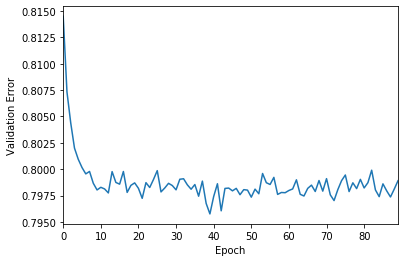

In [49]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [50]:
# 실험5 - 세개의 잠재요인 가진 행렬 인수분해를 사용한 추천 시스템

In [51]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [52]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 3s 41us/step - loss: 11.9604 - val_loss: 7.4372
Epoch 2/100
81191/81191 [==============================] - 3s 39us/step - loss: 4.2585 - val_loss: 2.4745
Epoch 3/100
81191/81191 [==============================] - 3s 41us/step - loss: 1.7447 - val_loss: 1.3502
Epoch 4/100
81191/81191 [==============================] - 3s 36us/step - loss: 1.0735 - val_loss: 0.9951
Epoch 5/100
81191/81191 [==============================] - 3s 37us/step - loss: 0.8566 - val_loss: 0.8760
Epoch 6/100
81191/81191 [==============================] - 3s 37us/step - loss: 0.7835 - val_loss: 0.8324
Epoch 7/100
81191/81191 [==============================] - 3s 37us/step - loss: 0.7578 - val_loss: 0.8166
Epoch 8/100
81191/81191 [==============================] - 3s 39us/step - loss: 0.7487 - val_loss: 0.8109
Epoch 9/100
81191/81191 [==============================] - 3s 40us/step - loss: 0.7451 - val_loss: 0.8

Minimum MSE:  0.7753249401132909


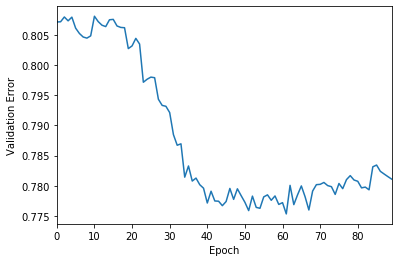

In [53]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [54]:
# 실험6 - 다섯개의 잠재요인 가진 행렬 인수분해를 사용한 추천 사스템

In [55]:
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [56]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 3s 43us/step - loss: 10.9779 - val_loss: 5.2631
Epoch 2/100
81191/81191 [==============================] - 3s 41us/step - loss: 2.8454 - val_loss: 1.6777
Epoch 3/100
81191/81191 [==============================] - 3s 37us/step - loss: 1.2196 - val_loss: 1.0309
Epoch 4/100
81191/81191 [==============================] - 3s 38us/step - loss: 0.8696 - val_loss: 0.8673
Epoch 5/100
81191/81191 [==============================] - 3s 37us/step - loss: 0.7816 - val_loss: 0.8303
Epoch 6/100
81191/81191 [==============================] - 3s 37us/step - loss: 0.7587 - val_loss: 0.8158
Epoch 7/100
81191/81191 [==============================] - 3s 36us/step - loss: 0.7526 - val_loss: 0.8111
Epoch 8/100
81191/81191 [==============================] - 3s 42us/step - loss: 0.7503 - val_loss: 0.8053
Epoch 9/100
81191/81191 [==============================] - 3s 40us/step - loss: 0.7493 - val_loss: 0.8

Minimum MSE:  0.7683288914563782


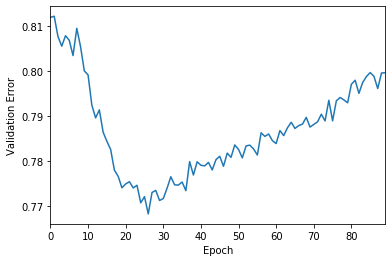

In [57]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [58]:
# 실험7 - RBMs 사용한 추천 시스템

In [59]:
# RBM 클래스 정의
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # 하이퍼파라미터 정의
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # 0행렬 사용한 가중치 및 편향 초기화
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [60]:
# 훈련 사이클 시작

# inputX를 float32로 데이터 유형 변환
inputX = ratings_train
inputX = inputX.astype(np.float32)

# 훈련을 위한 RBMs 파라미터 정의
rbm=RBM(1000,1000,1,1000,200)

In [61]:
# RBM 모델 훈련
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 1.110142
Epoch: 1 reconstruction error: 1.073877
Epoch: 2 reconstruction error: 1.089057
Epoch: 3 reconstruction error: 1.088477
Epoch: 4 reconstruction error: 1.090806
Epoch: 5 reconstruction error: 1.087798
Epoch: 6 reconstruction error: 1.090114
Epoch: 7 reconstruction error: 1.087842
Epoch: 8 reconstruction error: 1.088240
Epoch: 9 reconstruction error: 1.085129
Epoch: 10 reconstruction error: 1.086468
Epoch: 11 reconstruction error: 1.085783
Epoch: 12 reconstruction error: 1.099442
Epoch: 13 reconstruction error: 1.087507
Epoch: 14 reconstruction error: 1.094810
Epoch: 15 reconstruction error: 1.091269
Epoch: 16 reconstruction error: 1.094753
Epoch: 17 reconstruction error: 1.089862
Epoch: 18 reconstruction error: 1.095063
Epoch: 19 reconstruction error: 1.093250
Epoch: 20 reconstruction error: 1.095974
Epoch: 21 reconstruction error: 1.095014
Epoch: 22 reconstruction error: 1.093184
Epoch: 23 reconst

Epoch: 193 reconstruction error: 1.081643
Epoch: 194 reconstruction error: 1.080966
Epoch: 195 reconstruction error: 1.081987
Epoch: 196 reconstruction error: 1.082126
Epoch: 197 reconstruction error: 1.081905
Epoch: 198 reconstruction error: 1.080974
Epoch: 199 reconstruction error: 1.081151
Epoch: 200 reconstruction error: 1.081303
Epoch: 201 reconstruction error: 1.081417
Epoch: 202 reconstruction error: 1.081341
Epoch: 203 reconstruction error: 1.080991
Epoch: 204 reconstruction error: 1.080994
Epoch: 205 reconstruction error: 1.081280
Epoch: 206 reconstruction error: 1.080912
Epoch: 207 reconstruction error: 1.080188
Epoch: 208 reconstruction error: 1.080592
Epoch: 209 reconstruction error: 1.081310
Epoch: 210 reconstruction error: 1.081216
Epoch: 211 reconstruction error: 1.080709
Epoch: 212 reconstruction error: 1.081419
Epoch: 213 reconstruction error: 1.080793
Epoch: 214 reconstruction error: 1.080577
Epoch: 215 reconstruction error: 1.081509
Epoch: 216 reconstruction error: 1

Epoch: 389 reconstruction error: 1.075086
Epoch: 390 reconstruction error: 1.074918
Epoch: 391 reconstruction error: 1.074447
Epoch: 392 reconstruction error: 1.075243
Epoch: 393 reconstruction error: 1.074389
Epoch: 394 reconstruction error: 1.075091
Epoch: 395 reconstruction error: 1.074908
Epoch: 396 reconstruction error: 1.074463
Epoch: 397 reconstruction error: 1.074878
Epoch: 398 reconstruction error: 1.074896
Epoch: 399 reconstruction error: 1.074458
Epoch: 400 reconstruction error: 1.074304
Epoch: 401 reconstruction error: 1.074754
Epoch: 402 reconstruction error: 1.074347
Epoch: 403 reconstruction error: 1.074640
Epoch: 404 reconstruction error: 1.074442
Epoch: 405 reconstruction error: 1.075055
Epoch: 406 reconstruction error: 1.073843
Epoch: 407 reconstruction error: 1.074818
Epoch: 408 reconstruction error: 1.073913
Epoch: 409 reconstruction error: 1.074700
Epoch: 410 reconstruction error: 1.073661
Epoch: 411 reconstruction error: 1.074291
Epoch: 412 reconstruction error: 1

Epoch: 585 reconstruction error: 1.072351
Epoch: 586 reconstruction error: 1.071923
Epoch: 587 reconstruction error: 1.072498
Epoch: 588 reconstruction error: 1.072119
Epoch: 589 reconstruction error: 1.072595
Epoch: 590 reconstruction error: 1.072384
Epoch: 591 reconstruction error: 1.072196
Epoch: 592 reconstruction error: 1.072124
Epoch: 593 reconstruction error: 1.072363
Epoch: 594 reconstruction error: 1.072016
Epoch: 595 reconstruction error: 1.071990
Epoch: 596 reconstruction error: 1.072072
Epoch: 597 reconstruction error: 1.072235
Epoch: 598 reconstruction error: 1.072073
Epoch: 599 reconstruction error: 1.071982
Epoch: 600 reconstruction error: 1.072029
Epoch: 601 reconstruction error: 1.072181
Epoch: 602 reconstruction error: 1.071916
Epoch: 603 reconstruction error: 1.072240
Epoch: 604 reconstruction error: 1.071687
Epoch: 605 reconstruction error: 1.072235
Epoch: 606 reconstruction error: 1.072132
Epoch: 607 reconstruction error: 1.072080
Epoch: 608 reconstruction error: 1

Epoch: 781 reconstruction error: 1.071002
Epoch: 782 reconstruction error: 1.071254
Epoch: 783 reconstruction error: 1.070932
Epoch: 784 reconstruction error: 1.071040
Epoch: 785 reconstruction error: 1.070752
Epoch: 786 reconstruction error: 1.070547
Epoch: 787 reconstruction error: 1.071206
Epoch: 788 reconstruction error: 1.071061
Epoch: 789 reconstruction error: 1.070858
Epoch: 790 reconstruction error: 1.070868
Epoch: 791 reconstruction error: 1.070982
Epoch: 792 reconstruction error: 1.070832
Epoch: 793 reconstruction error: 1.070835
Epoch: 794 reconstruction error: 1.071102
Epoch: 795 reconstruction error: 1.070482
Epoch: 796 reconstruction error: 1.070678
Epoch: 797 reconstruction error: 1.070979
Epoch: 798 reconstruction error: 1.070521
Epoch: 799 reconstruction error: 1.070668
Epoch: 800 reconstruction error: 1.070990
Epoch: 801 reconstruction error: 1.070546
Epoch: 802 reconstruction error: 1.071180
Epoch: 803 reconstruction error: 1.070879
Epoch: 804 reconstruction error: 1

Epoch: 977 reconstruction error: 1.070357
Epoch: 978 reconstruction error: 1.070528
Epoch: 979 reconstruction error: 1.070614
Epoch: 980 reconstruction error: 1.070189
Epoch: 981 reconstruction error: 1.070825
Epoch: 982 reconstruction error: 1.070596
Epoch: 983 reconstruction error: 1.070341
Epoch: 984 reconstruction error: 1.070801
Epoch: 985 reconstruction error: 1.070382
Epoch: 986 reconstruction error: 1.070655
Epoch: 987 reconstruction error: 1.070357
Epoch: 988 reconstruction error: 1.070554
Epoch: 989 reconstruction error: 1.070259
Epoch: 990 reconstruction error: 1.070657
Epoch: 991 reconstruction error: 1.070451
Epoch: 992 reconstruction error: 1.070196
Epoch: 993 reconstruction error: 1.070526
Epoch: 994 reconstruction error: 1.070279
Epoch: 995 reconstruction error: 1.070395
Epoch: 996 reconstruction error: 1.070421
Epoch: 997 reconstruction error: 1.070277
Epoch: 998 reconstruction error: 1.070256
Epoch: 999 reconstruction error: 1.070475


Text(0, 0.5, 'Reconstruction Error')

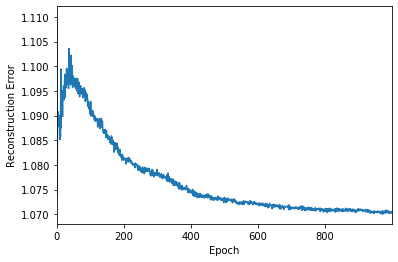

In [62]:
# 재구성 오차 그래프
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [63]:
# 검증 셋을 위한 평점 예측
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = \
    rbm.rbm_output(inputValidation)

In [64]:
# 검증 셋을 위한 MSE 계산 
predictionsArray = reconstructedOutput_validation
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 9.354189758368433
